## Food Swamp Analysis
- Replicating the approach of Cooksey-Stowers, K., Schwartz, M.B., & Brownell, K.D. (2017) 
- (Int. J. Environ. Res. Public Health 14(11), 1366) in identifying food swamps.

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from dataprocessing import get_blockgroupshape, get_foodswamp_data, get_blockgroup_data

c:\Users\megan\OneDrive\Desktop\capstone\MADS_Capstone\dataprocessing.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid'] = gdf['geometry'].centroid
c:\Users\megan\OneDrive\Desktop\capstone\MADS_Capstone\dataprocessing.py:60: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119) have mixed types. Specify dtype option on import or set low_memory=False.
  povdf = pd.read_csv(povurl)
c:\Users\megan\OneDrive\Desktop\capstone\MADS_Capstone\dataprocessing.py:70: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,

Food Swamp: 3264
Not Food Swamp: 15374


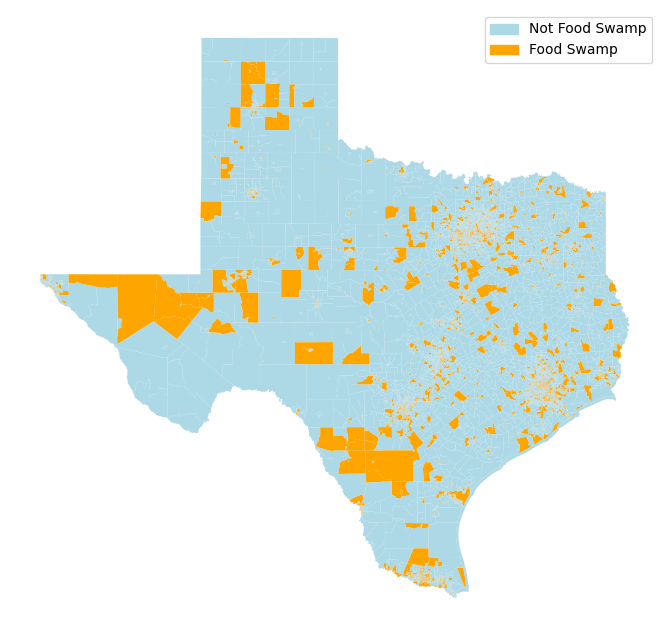

In [2]:
# Load data
blockgroup_shapefile = get_blockgroupshape()
blockgroup_data_df = get_blockgroup_data()
food_swamp_df = get_foodswamp_data()
food_swamp_gdf = gpd.GeoDataFrame(
    food_swamp_df, 
    geometry=gpd.points_from_xy(food_swamp_df.Longitude, food_swamp_df.Latitude)
)

fs_data = pd.merge(
    blockgroup_data_df, 
    blockgroup_shapefile, 
    left_on='Geo Index', 
    right_on='GEOIDFQ', 
    how='inner'
)
fs_data = gpd.GeoDataFrame(fs_data, geometry='geometry')
food_swamp_gdf = food_swamp_gdf.set_crs(fs_data.crs, allow_override=True)

# Identify food swamps in each blockgroup
food_within_blockgroups = gpd.sjoin(food_swamp_gdf, fs_data, how='left', predicate='within')
food_counts = (food_within_blockgroups.groupby(['Geo Index','Store Type'])
               .size()
               .unstack(fill_value=0))

if 'Fast Food' not in food_counts.columns:
    food_counts['Fast Food'] = 0
if 'Convenience Store' not in food_counts.columns:
    food_counts['Convenience Store'] = 0

food_counts['unhealthy'] = food_counts['Fast Food'] + food_counts['Convenience Store']
food_counts.reset_index(inplace=True)

fs_data = pd.merge(fs_data, food_counts[['Geo Index','unhealthy']], on='Geo Index', how='left')
fs_data['unhealthy'] = fs_data['unhealthy'].fillna(0)

threshold = 1
fs_data['food_swamp_flag'] = (fs_data['unhealthy'] > threshold).astype(int)

print("Food Swamp:", (fs_data['food_swamp_flag'] == 1).sum())
print("Not Food Swamp:", (fs_data['food_swamp_flag'] == 0).sum())

# Plot Choropleth Map of Food Swamp Flag
fig, ax = plt.subplots(figsize=(10, 8))
cmap = ListedColormap(['lightblue', 'orange'])
fs_data.plot(column='food_swamp_flag', cmap=cmap, legend=False, ax=ax)
ax.set_axis_off()
not_fs_patch = mpatches.Patch(color='lightblue', label='Not Food Swamp')
fs_patch = mpatches.Patch(color='orange', label='Food Swamp')
plt.legend(handles=[not_fs_patch, fs_patch], loc='upper right')
plt.show()